In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import time

In [2]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario, Policy, perform_experiments)
from ema_workbench import load_results
from ema_workbench.analysis import prim, dimensional_stacking, cart
from ema_workbench.util import ema_logging, utilities

from SALib.analyze import sobol
from ema_workbench.em_framework.evaluators import Samplers # 
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation

dike_model,  planning_steps = get_model_for_problem_formulation(5) 

In [4]:
policies = [Policy("base case without policy", **{k.name: 0 for k in dike_model.levers})]
problem = get_SALib_problem(dike_model.uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [5]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    sobol_results = evaluator.perform_experiments(scenarios=1000, policies = policies,
                                               uncertainty_sampling=Samplers.SOBOL)
    
experiments, outcomes = sobol_results


[MainProcess/INFO] pool started with 8 workers
/opt/anaconda3/lib/python3.9/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
  0%|                                     | 1/40000 [00:05<58:55:11,  5.30s/it]Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/ema_workbench/em_framework/callbacks.py", line 246, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'A.1_Dike Investment Costs 0'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/ema_workbench/em_framework/ema_multiprocessing.py", line 253, in run
    self.callback(*result.get())
  File "/opt/anaconda3/lib/python3.9/site-packages/e

In [6]:
# function to aggregate over time and locations
def aggregate_df(df):
    df_aggregate_time = pd.DataFrame()
    df_aggregate_time_location = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate_time_location[metric + ' time aggregate'] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric + ' time aggregate'] = df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric + ' time aggregate' for location in locations]
            df_aggregate_time_location[metric + ' time location aggregate'] = df_aggregate_time[columns_locations].sum(axis=1)
                    

    return df_aggregate_time, df_aggregate_time_location

In [7]:
outcomes_df = pd.DataFrame(outcomes)
experiments_df = pd.DataFrame(experiments)

In [8]:
df_t, df_tl = aggregate_df(outcomes_df)
df_tl

,Expected Annual Damage time location aggregate,Dike Investment Costs time location aggregate,Expected Number of Deaths time location aggregate,RfR Total Costs time aggregate,Expected Evacuation Costs time aggregate
0,6.852646e+07,-3284634592809167408,0.000000,0.0,0.0
1,1.229654e+08,-1391173225559840714,0.070716,0.0,0.0
2,1.235057e+08,-5648988551412999952,0.145164,0.0,0.0
3,1.235147e+08,71773920150907540,0.145187,0.0,0.0
4,5.535944e+07,-9198315266369388544,0.075025,0.0,0.0
...,...,...,...,...,...
39995,2.097000e+09,0,3.745557,0.0,0.0
39996,2.210428e+09,0,3.745557,0.0,0.0
39997,1.936286e+09,0,3.745557,0.0,0.0
39998,2.331739e+09,0,3.745557,0.0,0.0


In [9]:
x1 = df_tl['Expected Annual Damage time location aggregate'].to_numpy()
x2 = df_tl['Expected Number of Deaths time location aggregate'].to_numpy()

In [10]:
Si_Damage = sobol.analyze(problem, x1, 
                          calc_second_order=True, print_to_console=False)

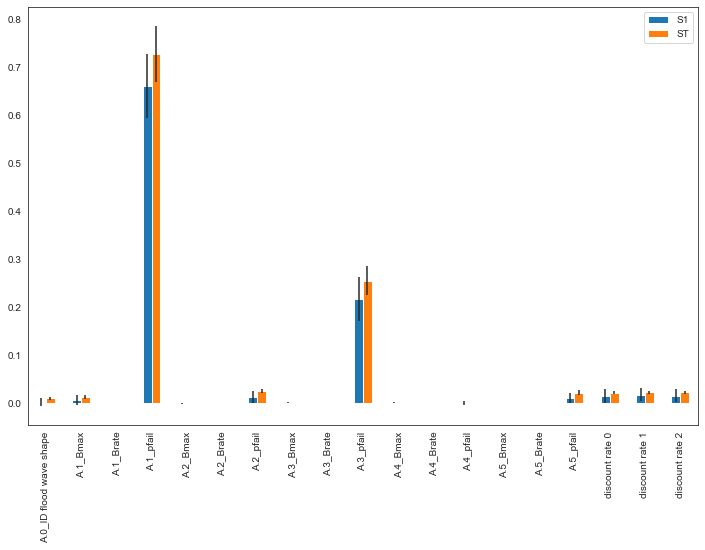

In [11]:
scores_filtered = {k: Si_Damage[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_Damage_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)


indices = Si_Damage_df[["S1", "ST"]]
err = Si_Damage_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(12, 10)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [12]:
Si_Deaths = sobol.analyze(problem, x2,
                  calc_second_order=True, print_to_console=False)

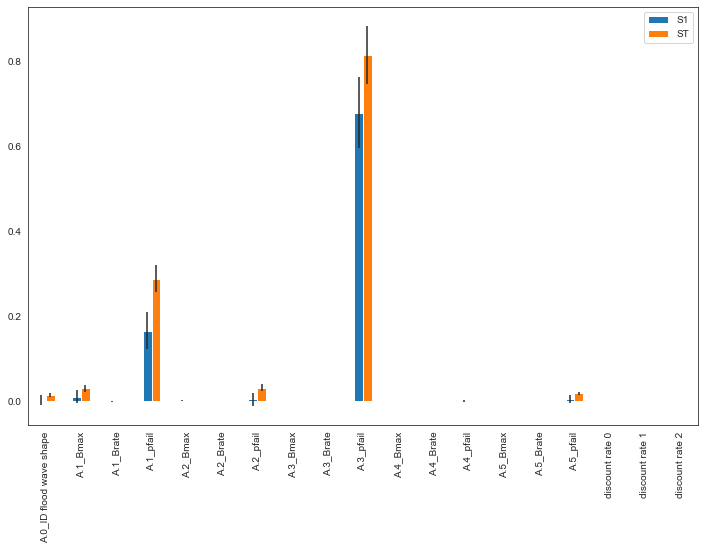

In [13]:
scores_filtered = {k: Si_Deaths[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_Deaths_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_Deaths_df[["S1", "ST"]]
err = Si_Deaths_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(12, 10)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [14]:
df_t

,A.1_Expected Annual Damage time aggregate,A.2_Expected Annual Damage time aggregate,A.3_Expected Annual Damage time aggregate,A.4_Expected Annual Damage time aggregate,A.5_Expected Annual Damage time aggregate,A.1_Dike Investment Costs time aggregate,A.2_Dike Investment Costs time aggregate,A.3_Dike Investment Costs time aggregate,A.4_Dike Investment Costs time aggregate,A.5_Dike Investment Costs time aggregate,A.1_Expected Number of Deaths time aggregate,A.2_Expected Number of Deaths time aggregate,A.3_Expected Number of Deaths time aggregate,A.4_Expected Number of Deaths time aggregate,A.5_Expected Number of Deaths time aggregate
0,6.852646e+07,0.000000e+00,0.000000e+00,0.0,0.0,0,4612377611241259008,140613493741008,5913662140216901632,4635929115948482560,0.000000,0.000000,0.00000,0.0,0.0
1,6.814554e+07,5.481991e+07,0.000000e+00,0.0,0.0,0,4606192858335019008,140613493741008,7809651250338746982,4639586125982203904,0.070716,0.000000,0.00000,0.0,0.0
2,6.852646e+07,5.497926e+07,0.000000e+00,0.0,0.0,0,4644021006132838400,140613493741008,3539956251103281952,4613637651566690304,0.071194,0.073970,0.00000,0.0,0.0
3,6.852646e+07,5.498820e+07,0.000000e+00,0.0,0.0,0,4608635973171937280,0,-9139773968658765164,4602911915637735424,0.071194,0.073994,0.00000,0.0,0.0
4,0.000000e+00,5.535944e+07,0.000000e+00,0.0,0.0,0,4605577131823464448,0,0,4642851675516698624,0.000000,0.075025,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,3.353393e+07,8.831139e+07,1.975154e+09,0.0,0.0,0,0,0,0,0,0.026670,0.091407,3.62748,0.0,0.0
39996,3.534780e+07,9.308822e+07,2.081992e+09,0.0,0.0,0,0,0,0,0,0.026670,0.091407,3.62748,0.0,0.0
39997,3.096388e+07,8.154320e+07,1.823779e+09,0.0,0.0,0,0,0,0,0,0.026670,0.091407,3.62748,0.0,0.0
39998,3.728773e+07,9.819702e+07,2.196255e+09,0.0,0.0,0,0,0,0,0,0.026670,0.091407,3.62748,0.0,0.0


In [15]:
x3 = df_t['A.1_Expected Annual Damage time aggregate'].to_numpy()
x4 = df_t['A.1_Expected Number of Deaths time aggregate'].to_numpy()

In [16]:
Si_Damage_l = sobol.analyze(problem, x3, 
                          calc_second_order=True, print_to_console=False)

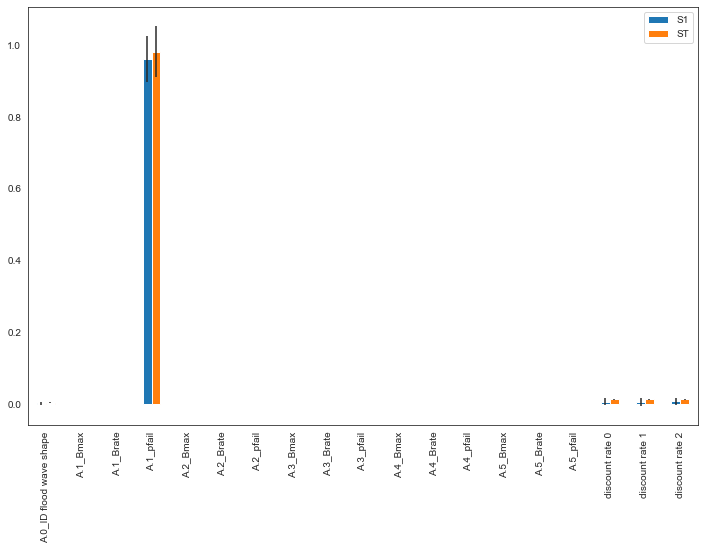

In [17]:
scores_filtered = {k: Si_Damage_l[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_Damage_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)


indices = Si_Damage_df[["S1", "ST"]]
err = Si_Damage_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(12, 10)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [18]:
Si_Deaths_l = sobol.analyze(problem, x4,
                  calc_second_order=True, print_to_console=False)

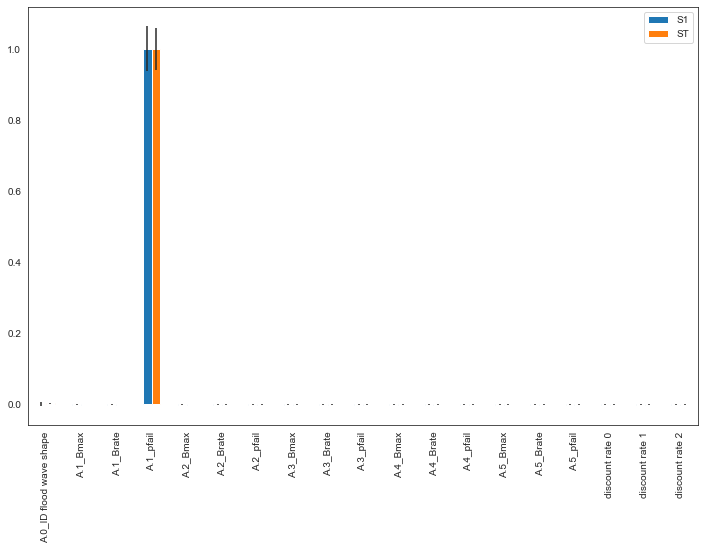

In [19]:
scores_filtered = {k: Si_Deaths_l[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_Deaths_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_Deaths_df[["S1", "ST"]]
err = Si_Deaths_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(12, 10)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [20]:
utilities.save_results(sobol_results, 'results/sobol_nopolicy_1000scen.csv')

[MainProcess/INFO] results saved successfully to /Users/dorriscorsten/Documents/EPA_Group7_MBDM/final assignment/results/sobol_nopolicy_1000scen.csv


In [21]:
# sobol_results=utilities.load_results('results/base_case_sobol_lever.csv')
# experiments, outcomes = sobol_results
# outcomes = pd.DataFrame(outcomes)
# experiments = pd.DataFrame(experiments)